In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA
import scipy.sparse.linalg as spLA
import networkx as nx

import sys
sys.path.insert(1, "../")

import SpringRank_tools as sr
import tools as tl

from time import time
from copy import deepcopy as copy

%load_ext autoreload
%aimport SpringRank_tools
%aimport tools
%autoreload 1

%matplotlib inline

## Update Process

In [13]:
def Laplacian(G):
    k_in = np.sum(G, 0)
    k_out = np.sum(G, 1)
    return np.diag(k_in + k_out) - (A + A.T)

def operator_P(x, P):
    if len(x.shape) == 2:
        x_P = x[P][:, P]
    elif len(x.shape) == 1:
        x_P = x[P]
    else:
        raise ValueError("Invalid shape")
    return x_P

def cache_neighbors(G):
    neighbors_cache = {}
    N = G.shape[0]
    for node in range(N):
        idx_0 = set(np.nonzero(G[[node]])[1])
        idx_1 = set(np.nonzero(G[:,[node]])[0])
        neighbors_cache[node] = idx_0.union(idx_1)
    return neighbors_cache

def get_neighbors(P, neighbors_cache):
    neighbors = set()
    for node in P:
        neighbors = neighbors.union(neighbors_cache[node])
    return list(neighbors)

def collect_neighborhood(P, order, neighbors_cache):
    neighbors = set(P)
    for k in range(order):
        N = get_neighbors(list(neighbors), neighbors_cache)
        neighbors = neighbors.union(N)
    return list(neighbors)

In [15]:
def update_ranks(A, s_0, P):
    L = Laplacian(A)
    s_est = copy(s_0)
    d_hat = np.sum(A, 1) - np.sum(A, 0)
    RHS = d_hat - np.matmul(L, s_0)
    
    L_p = operator_P(L, P)    
    RHS_p = operator_P(RHS, P)
    
    result = spLA.spsolve(L_p, RHS_p)
    delta_p = result
    
    delta_p = delta_p - np.mean(delta_p)
    
    s_est[P] = s_est[P] + delta_p
    
    return s_est, delta_p

def lagrange_multipliers(A, s_0, neighbors):
    L = Laplacian(A)
    K = np.copy(L)
    
    ctr = 0
    N = A.shape[0]
    M = N - len(neighbors)
    fixed_nodes_matrix = np.zeros((N, M))
    for idx in range(N):
        if idx not in neighbors:
            fixed_nodes_matrix[idx, ctr] = 1
            ctr += 1
    K = np.append(K, fixed_nodes_matrix, axis=1)
    K = np.append(K, np.append(fixed_nodes_matrix.T, np.zeros((M, M)), axis=1), axis=0)
    
    fixed_nodes = list(set(range(N)) - set(neighbors))
    RHS = np.sum(A, axis=1) - np.sum(A, axis=0)
    RHS = np.append(RHS, s_0[fixed_nodes], axis=0)

    result = spLA.lsqr(K, RHS)
    x = result[0]
    s_est = x[:N]
    lamb = x[N:]
    
    return s_est, lamb 

def kth_order_update(A, s_0, N0, order, option="reduced", return_compute_times=False):
    
    start_time = time()
    neighbors_cache = cache_neighbors(A)
    N = collect_neighborhood(N0, order, neighbors_cache)
    end_time = time()
    neighbor_time = end_time - start_time
    
    start_time = time()
    
    if option == "reduced":
#         print("Computing updates via solving the new Hamiltonian")
        s_est, delta_p = update_ranks(A, s_0, N)
    elif option == "lagrange":
#         print("Computing ranks via Lagrange multipliers")
        s_est, lamb = lagrange_multipliers(A, s_0, N)
    
    end_time = time()
    solve_time = end_time - start_time
    
    if return_compute_times:
        return s_est, N, (neighbor_time, solve_time)
    else:
        return s_est, N

## Simple Test Case #1
The original system is essentially a directed link list. The final system closes the linked list creating a cycle. We expect all the nodes in the final system to have the same rank.

In [8]:
N = 10
A0 = np.zeros((N, N))
for i in range(N-1):
    A0[i, i+1] = 1
s0 = sr.SpringRank(A0)
s0 = tl.adjust_ranks(s0, A0, p_ij=0.999)

print(s0)

[52.12183977 46.33061583 40.53937633 34.74812459 28.95684705 23.16553783
 17.37419254 11.58281466  5.7914168   0.        ]


In [9]:
A = np.copy(A0)
A[N-1, 0] = 1

s = sr.SpringRank(A)
s = tl.adjust_ranks(s, A, p_ij=0.999)

print(s)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [14]:
k = 4
sk, neighbors_k = kth_order_update(A, s0, N0=[N-1, 0], order=k)

sk = tl.shift_ranks(sk)

print(sk)

Computing updates via solving the new Hamiltonian
[0.00000000e+00 0.00000000e+00 0.00000000e+00 3.55271368e-15
 7.10542736e-15 1.06581410e-14 1.06581410e-14 1.06581410e-14
 7.10542736e-15 3.55271368e-15]


Okay, works!

## Simple Test Case #2
Here, the final system is a directed linked list. The original system misses an edge that makes it a linked list.

In [24]:
N = 10
missing_node = np.random.randint(0, N-1)
A0 = np.zeros((N, N))
for i in range(N-1):
    if i == missing_node:
        continue
    A0[i, i+1] = 1
# if i != (N-1):
#     A0[N-1, 0] = 1
s0 = sr.SpringRank(A0)
s0 = tl.adjust_ranks(s0, A0, p_ij=0.999)

print(missing_node)
print(s0)

7
[40.54002038 34.74858916 28.95715788 23.16572653 17.37429507 11.58286352
  5.79143181  0.         43.43573637 37.64430445]


In [23]:
A = np.copy(A0)
A[missing_node, missing_node+1] = 1

s = sr.SpringRank(A)
s = tl.adjust_ranks(s, A, p_ij=0.999)

print(s)

[52.12183977 46.33061583 40.53937633 34.74812459 28.95684705 23.16553783
 17.37419254 11.58281466  5.7914168   0.        ]


In [27]:
k = 5
sk, neighbors_k = kth_order_update(A, s0, N0=[missing_node, missing_node+1], order=k)

# sk = tl.adjust_ranks(sk, A, p_ij=0.999, interval=(-1000, 100))

print(neighbors_k)
print(sk)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[18.39943658 17.39943658 16.39943658 15.39943658 14.39943658 13.39943658
 12.39943658 11.39943658 10.39943658  9.39943658]


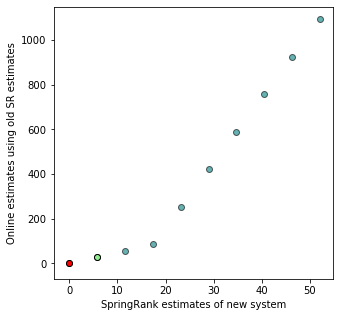

In [126]:
plt.figure(figsize=(5,5))

plt.scatter(s, sk, color="teal", edgecolor="black", alpha=0.6)

plt.scatter(s[missing_node], sk[missing_node], color="lightgreen", edgecolor="black")
plt.scatter(s[missing_node+1], sk[missing_node+1], color="red", edgecolor="black")

plt.xlabel("SpringRank estimates of new system")
plt.ylabel("Online estimates using old SR estimates")

plt.show()

Okay, works!

## Test on large network

In [16]:
def generate_large_network(N, p, k):
    n = k / p
    A = np.random.binomial(n, p, size=(N, N))
    return A

In [52]:
beta = 0.5
p_ij = 1 / (1 + np.exp(-2*beta))
alpha = 1
N = 10000
K = 10

A_0 = sr.SpringRank_planted_network(N, beta, alpha, K)
# A_0 = generate_large_network(N, 0.2, K)
s_0 = sr.SpringRank(A_0)
s_0 = tl.adjust_ranks(s_0, A_0, p_ij=p_ij)

In [53]:
node_x = 35
node_y = 70
A_xy = 1
A_yx = 0

A = copy(A_0)
A[node_x, node_y] += A_xy
A[node_y, node_x] += A_yx
P = [node_x, node_y]

In [54]:
s = sr.SpringRank(A)
s = tl.adjust_ranks(s, A, p_ij=p_ij)

print("Difference:")
print(LA.norm(s - s_0, ord=1))
print(LA.norm(s - s_0, ord=1) / LA.norm(s_0, ord=1))

Difference:
2.8053636724729585
3.866058325155729e-05


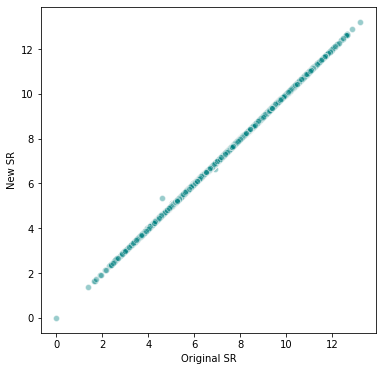

In [55]:
plt.figure(figsize=(6, 6))

plt.scatter(s_0, s, color='teal', edgecolor='white', alpha=0.4)

plt.xlabel("Original SR")
plt.ylabel("New SR")

plt.show()

### kth order update

In [56]:
s_all = []
fraction_nodes = []
neighbors = []
errors = []
elapsed_times = []
neighbor_times = []
solve_times = []

max_order = 5
orders = list(range(max_order+1))

num_reps = 1

baseline_time = 0
for i in range(num_reps):
    start_time = time()
    _ = sr.SpringRank(A)
    end_time = time()
    baseline_time += end_time - start_time
baseline_time /= num_reps

for k in orders:
    
    elapsed_time_k = 0
    neighbor_time_k = 0
    solve_time_k = 0
    for i in range(num_reps):
        start_time = time()
        s_k, N_k, times = kth_order_update(A, s_0, P, order=k, option="lagrange", return_compute_times=True)
        end_time = time()
        elapsed_time_k += end_time - start_time
        neighbor_time_k += times[0]
        solve_time_k += times[1]
    
    
    elapsed_times.append(elapsed_time_k / num_reps)
    neighbor_times.append(neighbor_time_k / num_reps)
    solve_times.append(solve_time_k / num_reps)
    
    fraction_k = len(N_k) / N
    fraction_nodes.append(fraction_k)
    
    s_k = tl.shift_ranks(s_k)
    s_k = tl.adjust_ranks(s_k, A, p_ij=p_ij)
    s_all.append(s_k)
    neighbors.append(N_k)
    
    error_k = LA.norm(s_k - s, ord=2)
    errors.append(error_k)

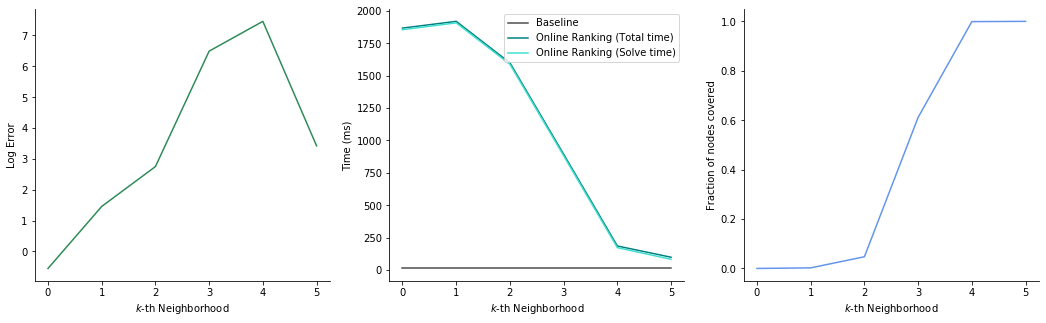

In [60]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

for i in range(3):
    ax[i].set_xlabel(r"$k$-th Neighborhood")
    ax[i].set_xticks(orders)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)

ax[0].plot(orders, np.log(errors), color="seagreen")
ax[0].set_ylabel("Log Error")


ax[1].plot(orders, [baseline_time]*len(orders), color='black', alpha=0.7, label="Baseline")
ax[1].plot(orders, elapsed_times, color="teal", label="Online Ranking (Total time)")
# ax[1].plot(orders, neighbor_times, color="red", label="Online Ranking (Neighbor collection)")
ax[1].plot(orders, solve_times, color="turquoise", label="Online Ranking (Solve time)")
ax[1].set_ylabel("Time (ms)")
ax[1].legend()


ax[2].plot(orders, fraction_nodes, color="cornflowerblue")
ax[2].set_ylabel("Fraction of nodes covered")

plt.savefig("../../figures/OnePassOnlineGraphs_" + str(N) + ".png", dpi=200, bbox_inches="tight")

plt.show()

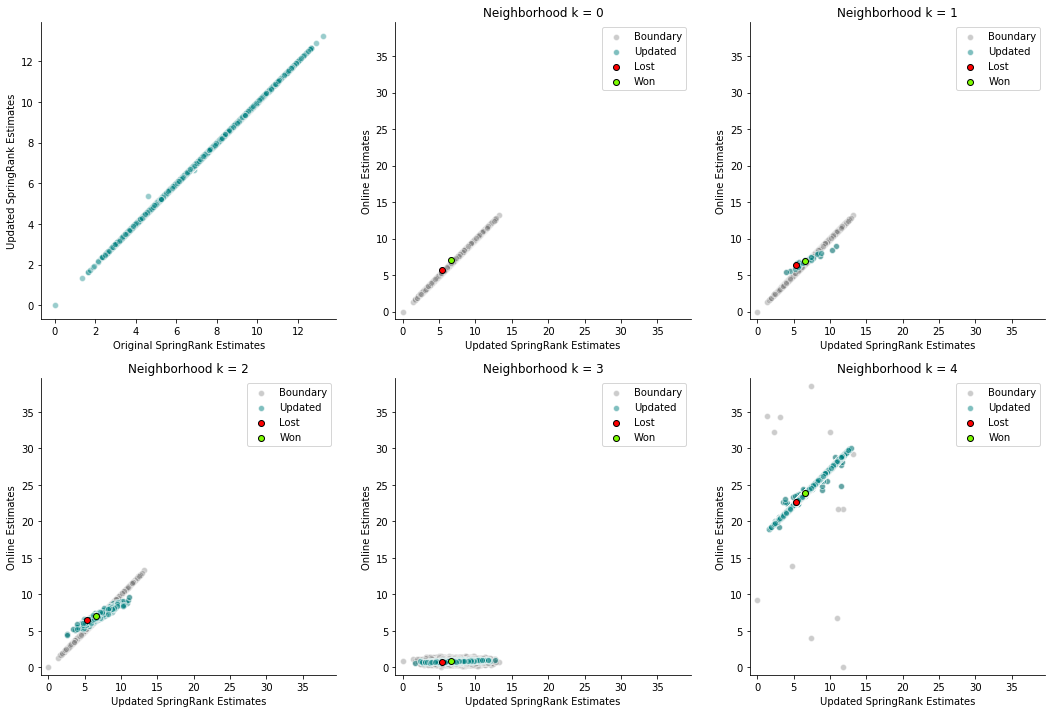

In [61]:
fig, ax = plt.subplots(2, 3, figsize=(18, 12))

ax[0,0].scatter(s_0, s, color='teal', edgecolor='white', alpha=0.4)
ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)

ax[0,0].set_xlabel("Original SpringRank Estimates")
ax[0,0].set_ylabel("Updated SpringRank Estimates")
# ax[0,0].set_title("")

for i in range(2):
    for j in range(3):
        if j == 0 and i == 0:
            continue
        k = i*3 + j - 1
        
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].spines['right'].set_visible(False)

        ax[i,j].scatter(s, s_all[k], color="grey", edgecolor="white", alpha=0.4, label="Boundary")

        ax[i,j].scatter(s[neighbors[k]], s_all[k][neighbors[k]],
                        color="teal", edgecolor="white", alpha=0.5, label="Updated")

        ax[i,j].scatter(s[node_x], s_all[k][node_x], color="red", edgecolor="black", label="Lost")
        ax[i,j].scatter(s[node_y], s_all[k][node_y], color="lawngreen", edgecolor="black", label="Won")

        ax[i,j].set_xlim(min(np.min(s), np.min(s_all))-1, max(np.max(s), np.max(s_all))+1)
        ax[i,j].set_ylim(min(np.min(s), np.min(s_all))-1, max(np.max(s), np.max(s_all))+1)

        ax[i,j].set_xlabel("Updated SpringRank Estimates")
        ax[i,j].set_ylabel("Online Estimates")
        ax[i,j].set_title(r"Neighborhood k = {}".format(k))
        
        ax[i,j].legend()

plt.savefig("../../figures/OnePassOnlineUpdates" + str(N) + ".png", dpi=200, bbox_inches="tight")
plt.show()